## Image classificaton for dataset MNIST

In [1]:
import os
import cv2
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.utils import to_categorical, plot_model
from keras.callbacks import ModelCheckpoint
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Dropout, Flatten, Conv2D, Conv2DTranspose, MaxPool2D, UpSampling2D, BatchNormalization, Input, ZeroPadding2D, Concatenate


# custom package imports
from Helpers_Classification import helper_model
from Helpers_Classification import helper_data
from Helpers_Classification import helper_stats

Using TensorFlow backend.


### Load train and test dataset

In [2]:
# NOTE: specify destination paths
srcPath = r'C:\Users\vase_\Downloads\ComputerVision\Data\Minst'
dstResultsPath = r'C:\Users\vase_\Downloads\ComputerVision\Data\Results'
dstModelsPath = r'C:\Users\vase_\Downloads\ComputerVision\Data\Models'

# --- variables ---
imgDims = {'rows': 28, 'cols': 28}
num_classes = 10
image_depth = 1

# --- load and format data ---
# load full dataset into memory - image data and labels
x_train, y_train = helper_data.read_images(os.path.join(srcPath, 'train'), None, image_depth)
x_test, y_test = helper_data.read_images(os.path.join(srcPath, 'test'), None, image_depth)
y_test = to_categorical(y_test, num_classes)

print(f'Training dataset shape: {x_train.shape}')
print(f'Number of training samples: {x_train.shape[0]}')
print(f'Number of test samples: {x_test.shape[0]}')

5923it [00:05, 1163.49it/s]
6742it [00:04, 1407.19it/s]
5958it [00:04, 1402.37it/s]
6131it [00:04, 1432.47it/s]
5842it [00:03, 1525.88it/s]
5421it [00:03, 1699.73it/s]
5918it [00:03, 1863.00it/s]
6265it [00:03, 1678.56it/s]
5851it [00:03, 1655.31it/s]
5949it [00:03, 1952.14it/s]
980it [00:01, 682.23it/s]
1135it [00:00, 1701.48it/s]
1032it [00:00, 1698.99it/s]
1010it [00:00, 1434.00it/s]
982it [00:00, 1163.44it/s]
892it [00:00, 1424.89it/s]
958it [00:00, 1174.79it/s]
1028it [00:00, 1128.60it/s]
974it [00:00, 1113.15it/s]
1009it [00:00, 1129.88it/s]


Training dataset shape: (60000, 28, 28, 1)
Number of training samples: 60000
Number of test samples: 10000


### Create training version

In [3]:
# --- paths ---
version = 'LV1_8'

# optimization hyperprameters
batch_size = 128
epochs = 10
lr = 0.0001

# create folders to save data from the current execution
if not os.path.exists(os.path.join(dstResultsPath, version)):
    os.mkdir(os.path.join(dstResultsPath, version))
else:
    # to avoid overwriting training results
    print(f"Folder name {version} exists.")
    exit(1)

resultsPath = os.path.join(dstResultsPath, version)

if not os.path.exists(os.path.join(dstModelsPath, version)):
    os.mkdir(os.path.join(dstModelsPath, version))
modelsPath = os.path.join(dstModelsPath, version)

### Create model

In [8]:
# trim training data and one-hot encoding of labels
x_train_trim, y_train_trim = helper_data.trim_train_data(x_train,y_train,None)
y_train_trim = to_categorical(y_train_trim, num_classes)

# create validation dataset (image and label data is shuffled in both datasets)
X_train, X_val, Y_train, Y_val = train_test_split(x_train_trim, y_train_trim,
                                                  test_size=0.2,    # assign random 20% of the samples to the validation set
                                                  random_state=42)     # fixed random seed enables repeatability of sample choice across executions


# --- construct model ---
#model = helper_model.construct_model(num_classes)   # build model architecture
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_normal'))
# model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))     # softmax for multi-class classification

# compile model
model.compile(loss=categorical_crossentropy,    # categorical crossentropy for multi-class classification
              optimizer=Adam(lr=lr),
              metrics=['accuracy'])
# SGD(lr=lr, momentum=0.0, decay=0.0)

# --- fit model ---
model_checkpoint = ModelCheckpoint(filepath=os.path.join(modelsPath, 'checkpoint-{epoch:03d}-{val_accuracy:.4f}.hdf5'),   # epoch number and val accuracy will be part of the weight file name
                                   monitor='val_accuracy',      # metric to monitor when selecting weight checkpoints to save
                                   verbose=1,
                                   save_best_only=True)     # True saves only the weights after epochs where the monitored value (val accuracy) is improved


### Train model

In [9]:
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,  # number of samples to process before updating the weights
                    epochs=epochs,
                    callbacks=[model_checkpoint],
                    verbose=0,
                    validation_data=(X_val, Y_val))


Epoch 00001: val_accuracy improved from -inf to 0.91750, saving model to C:\Users\vase_\Downloads\ComputerVision\Data\Models\LV1_8\checkpoint-001-0.9175.hdf5

Epoch 00002: val_accuracy improved from 0.91750 to 0.96733, saving model to C:\Users\vase_\Downloads\ComputerVision\Data\Models\LV1_8\checkpoint-002-0.9673.hdf5

Epoch 00003: val_accuracy improved from 0.96733 to 0.97308, saving model to C:\Users\vase_\Downloads\ComputerVision\Data\Models\LV1_8\checkpoint-003-0.9731.hdf5

Epoch 00004: val_accuracy improved from 0.97308 to 0.97642, saving model to C:\Users\vase_\Downloads\ComputerVision\Data\Models\LV1_8\checkpoint-004-0.9764.hdf5

Epoch 00005: val_accuracy improved from 0.97642 to 0.98033, saving model to C:\Users\vase_\Downloads\ComputerVision\Data\Models\LV1_8\checkpoint-005-0.9803.hdf5

Epoch 00006: val_accuracy improved from 0.98033 to 0.98317, saving model to C:\Users\vase_\Downloads\ComputerVision\Data\Models\LV1_8\checkpoint-006-0.9832.hdf5

Epoch 00007: val_accuracy did 

KeyboardInterrupt: 

## Save and evaluate model

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               401536    
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1290      
Total params: 405,306
Trainable params: 405,306
Non-trainable params: 0
________________________________________________

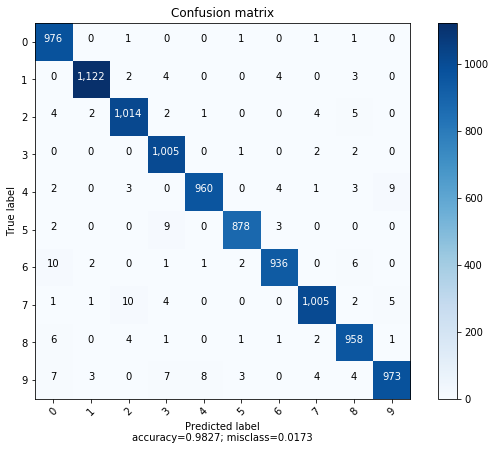

In [23]:
# save model architecture
print(model.summary())      # parameter info for each layer
with open(os.path.join(modelsPath, 'modelSummary.txt'), 'w') as fh:     # save model summary
    model.summary(print_fn=lambda x: fh.write(x + '\n'))
plot_model(model, to_file=os.path.join(modelsPath, 'modelDiagram.png'), show_shapes=True)   # save diagram of model architecture

# save model configuration and weights
model_json = model.to_json()  # serialize model architecture to JSON
with open(os.path.join(os.path.join(modelsPath, 'model.json')), "w") as json_file:
    json_file.write(model_json)
model.save_weights(os.path.join(modelsPath, 'model.h5'))  # serialize weights to HDF5
print("Saved model to disk.")

# --- save training curves and logs ---
helper_stats.save_training_logs(history=history, dst_path=modelsPath)
# --- apply model to test data ---
Y_test_pred = model.predict(x_test, verbose=1)

# --- evaluate model ---
# accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# confusion matrix
labels = [x for x in range(10)]

# convert one-hot encoded vectors to 1D list of classes
y_test_list = np.argmax(y_test, axis=1)
Y_test_pred_list = np.argmax(Y_test_pred, axis=1)

cm = confusion_matrix(y_test_list, Y_test_pred_list, labels)    # takes 1D list of classes as input

# plot confusion matrix
target_names = [str(x) for x in labels]
fig = helper_stats.plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=False)
fig.savefig(os.path.join(modelsPath, 'confusionMatrix.png'), dpi=fig.dpi)    # save confusion matrix as figure

# --- save misclassified test samples ---
# find indices of misclassified samples
missed = [ind for ind, elem in enumerate(Y_test_pred_list) if elem != y_test_list[ind]]

for i in missed:
    cv2.imwrite(os.path.join(resultsPath, str(i).zfill(6) + '_' + str(Y_test_pred_list[i]) + '_' + str(y_test_list[i]) + '.png'),
                (x_test[i] * 255).astype(np.uint8))     # transform value range inback to [0, 255]
    # file name: OrdinalNumberOfSample_PredictedClass_TrueClass.png